# Grafazo

### Qué va a analizar nuestro grafo?

Analizar "camadas" de gente -> cursaron juntos y les fue parecido en la facu

### Qué queremos responder?

Con quien puedo hacer trabajos prácticos?

### Cómo es el grafo?

- Nodos: usuarios
- Aristas: cursar misma materia mismo cuatri
- Peso: correlacion entre notas(???)

### Ejemplo de conexion:

X y yo cursamos ...

In [ ]:
import pandas as pd

df = pd.read_pickle('fiuba-map-data.pickle')
df.sample(3)

,Padron,Carrera,Orientacion,Final de Carrera,materia_id,materia_nota,materia_cuatrimestre,aplazos,optativas
13226,107115,informatica,NaN,NaN,75.08,-2.0,2022.0,NaN,NaN
11222,102445,informatica,Gestión Industrial de Sistemas,tpp,CBC,0.0,NaN,NaN,NaN
1935,105703,informatica,Gestión Industrial de Sistemas,tpp,75.41,9.0,2020.5,NaN,NaN


In [ ]:
df_nodes_metadata = df[df.columns & ["Padron", "Carrera", "aplazos", "optativas", "checkboxes"]]
df_nodes_metadata = df_nodes_metadata[df_nodes_metadata["aplazos"].notnull() | df_nodes_metadata["optativas"].notnull()]
df_nodes_metadata = df_nodes_metadata.groupby(["Padron", "Carrera"], as_index=False).first()

df_nodes = df[["Padron", "Carrera", "Orientacion", "Final de Carrera"]]
df_nodes = df_nodes.drop_duplicates()
df_nodes = df_nodes.merge(df_nodes_metadata, how="outer")
df_nodes.set_index("Padron", inplace=True)
display(df_nodes.sample(3))

from itertools import combinations
df_edges = (df[df['materia_cuatrimestre'].notnull()]
     .groupby(['materia_id', 'materia_cuatrimestre'])[['Padron', 'materia_nota']]
     .apply(lambda x : list(combinations(x.values,2)))
     .apply(pd.Series)
     .stack()
     .reset_index(level=0, name='Usuarios')
)

df_edges = df_edges.reset_index()
df_edges[['src', 'dst']] = df_edges['Usuarios'].tolist()
df_edges[['src_padron', 'src_nota']] = df_edges['src'].tolist()
df_edges[['dst_padron', 'dst_nota']] = df_edges['dst'].tolist()
df_edges = df_edges[['src_padron', 'dst_padron', 'materia_cuatrimestre', 'materia_id', 'src_nota', 'dst_nota']]
display(df_edges.sample(3))

/tmp/ipykernel_33850/1168196422.py:1: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  df_nodes_metadata = df[df.columns & ["Padron", "Carrera", "aplazos", "optativas", "checkboxes"]]


,Carrera,Orientacion,Final de Carrera,aplazos,optativas
Padron,,,,,
107729,informatica,NaN,NaN,NaN,NaN
100680,informatica,Sistemas Distribuidos,tpp,NaN,NaN
109492,informatica,NaN,tpp,NaN,NaN


/tmp/ipykernel_33850/1168196422.py:15: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  .apply(pd.Series)


,src_padron,dst_padron,materia_cuatrimestre,materia_id,src_nota,dst_nota
127145,104393,102396,2024.5,75.61,-2.0,-2.0
84724,107024,104928,2021.5,75.12,-2.0,-2.0
64680,105267,103784,2021.5,75.08,8.0,10.0


In [ ]:
import networkx as nx
G = nx.from_pandas_edgelist(df_edges, 
                            source='src_padron', 
                            target='dst_padron', 
                            edge_attr=['materia_id','materia_cuatrimestre', 'src_nota', 'dst_nota'], 
                            create_using=nx.MultiGraph())

nx.set_node_attributes(G, df_nodes.to_dict('index'))
print(G)

MultiGraph with 383 nodes and 129696 edges


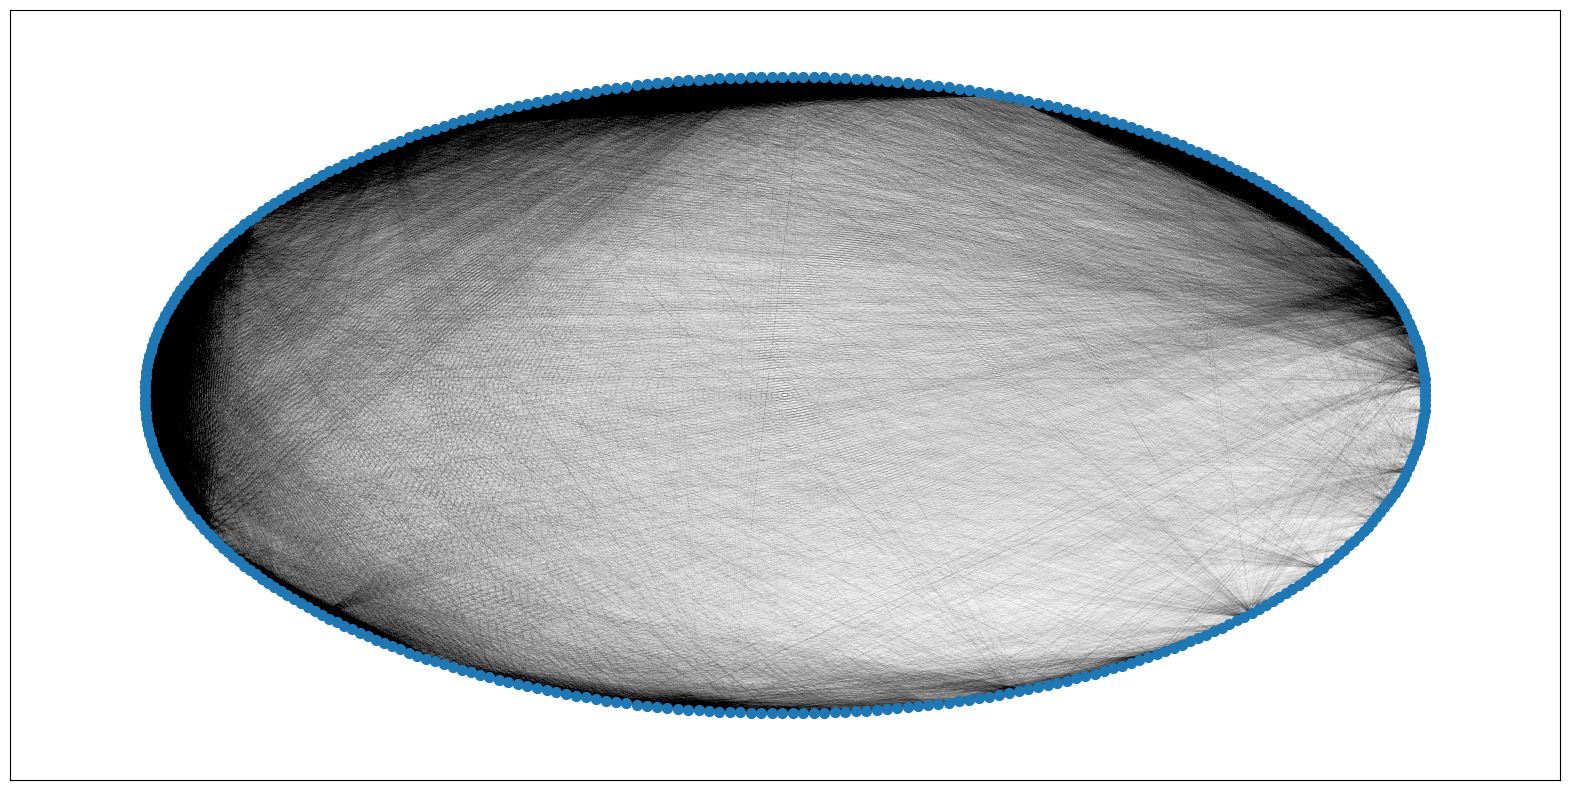

In [ ]:
# Veamos el grafo
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
nx.draw_networkx(G, pos=nx.circular_layout(G), width=0.005, node_size=50, with_labels=False)

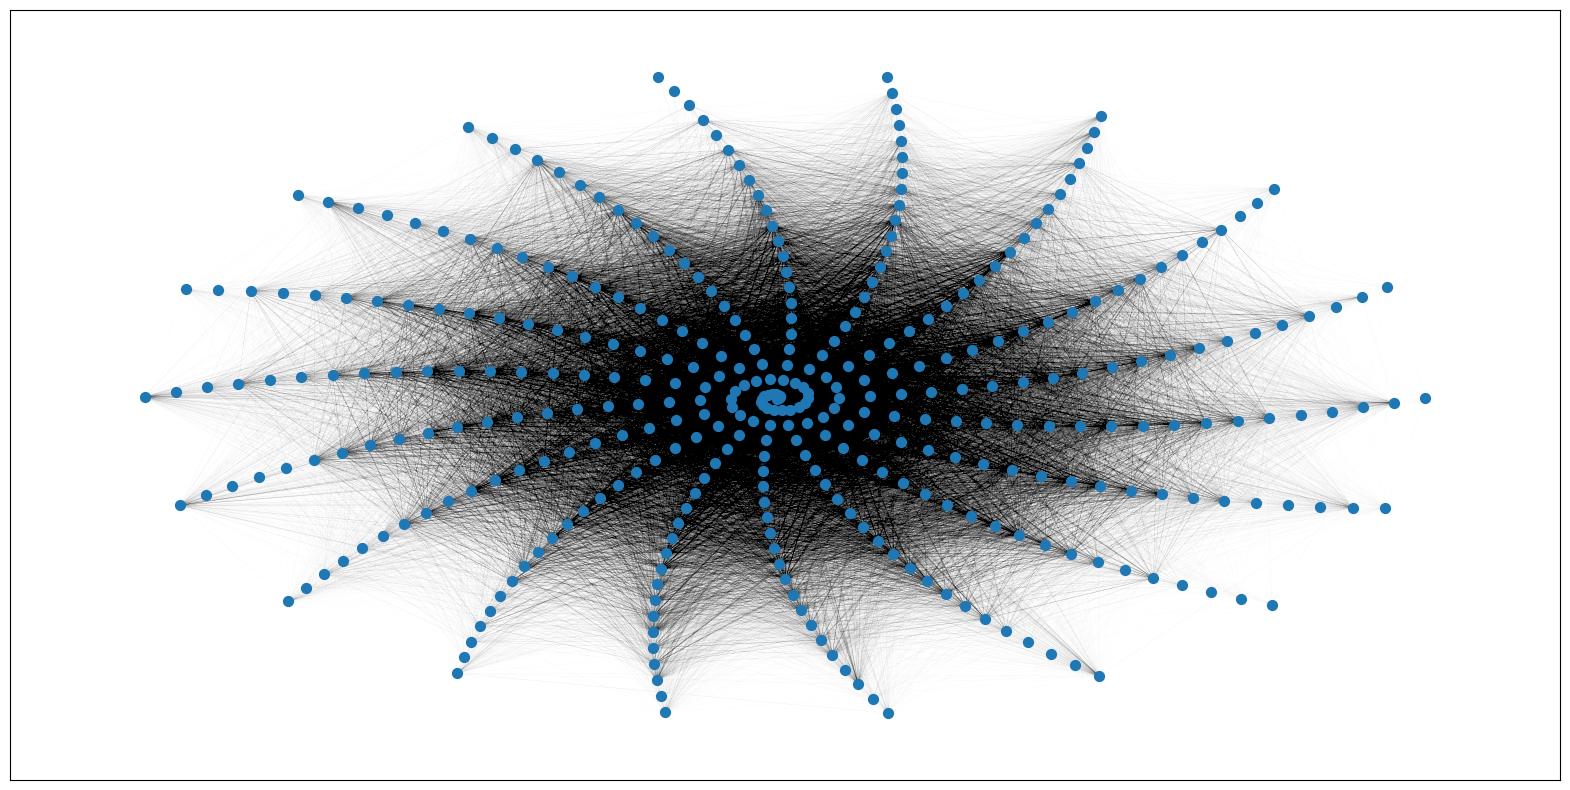

In [ ]:
# Again!
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
nx.draw_networkx(G, pos=nx.spiral_layout(G), width=0.005, node_size=50, with_labels=False)

In [ ]:
# # Solo como demo: ahora veamos el grafo, pero dibujemos todas las aristas
# # Robadisimo de: https://stackoverflow.com/a/60638452
# pos = nx.random_layout(G)
# nx.draw_networkx_nodes(G, pos)
# ax = plt.gca()
# for e in G.edges:
#     ax.annotate("",
#                 xy=pos[e[0]], xycoords='data',
#                 xytext=pos[e[1]], textcoords='data',
#                 arrowprops=dict(arrowstyle="-", color="0.5",
#                                 connectionstyle="arc3,rad=rr".replace('rr',str(0.3*e[2]))),
#                 )
# plt.axis('off')
# plt.show()

In [ ]:
print(f"""
  El diámetro de la red: {nx.diameter(G)}
  El grado promedio de la red: {sum([n[1] for n in G.degree()]) / len(G):.2f}
  TODO: Los allegados promedio de la red: 
  Puentes globales: {list(nx.bridges(G))}
""")


  El diámetro de la red: 4
  El grado promedio de la red: 677.26
  TODO: Los allegados promedio de la red: 
  Puentes globales: [('98439', '99796')]



In [ ]:
from networkx.algorithms import community
louvain = community.louvain_communities(G)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random

plt.figure(figsize=(20,10))

draw_nodes = {}
colors = random.sample(list(mcolors.TABLEAU_COLORS), len(louvain))
for louvaincommunity, color in zip(louvain, colors):
    draw_nodes.update({n: color for n in louvaincommunity})
    
plt.title("Louvain Communities")
nx.draw_networkx(G, 
                 nodelist=draw_nodes.keys(), 
                 node_color=list(draw_nodes.values()), 
                 width=0.05, 
                 pos=nx.kamada_kawai_layout(G),
                 font_size=10)

In [ ]:
# Todo: sacar distribucion de padrones de cada comunidad, para poder clasificar
# as in "esta es la comunidad de los jovenes, esta es la de los viejos, esta no tiene patron, etc"
louvain

In [ ]:
subnetwork = nx.subgraph(G, max(louvain, key=len))
subnetwork_louvain = community.louvain_communities(subnetwork)
plt.figure(figsize=(20,10))

draw_nodes = {}
colors = random.sample(list(mcolors.TABLEAU_COLORS), len(subnetwork_louvain))
for louvain, color in zip(subnetwork_louvain, colors):
    draw_nodes.update({n: color for n in louvain})
    
plt.title("Louvain Communities (of the OG Louvain Community with the most nodes)")
nx.draw_networkx(subnetwork, 
                 nodelist=draw_nodes.keys(), 
                 node_color=list(draw_nodes.values()), 
                 width=0.05, 
                 pos=nx.kamada_kawai_layout(subnetwork),
                 font_size=10)

In [ ]:
subnetwork_louvain

In [ ]:
# todo: usar graphrole y rolx

In [ ]:
# todo: ejercicio 5 de parcialito 3

In [ ]:
# todo: leer TODA la documentacion de "algorithms" de nx y ver que aplica aca
# https://networkx.org/documentation/stable/reference/algorithms/index.html

In [ ]:
# - Los 3 notebooks de grafos hacen exactamente el mismo analisis, pero con distintas conclusiones
# - Cada notebook de grafo devuelve un __algo__ que sea util y valioso para el usuario (despues vemos como se lo proveemos)
#   y la respuesta puede ser o de comunidad o de roles, hay que ver que es lo adecuado.